## 필요패키지 다운 및 버전 확인

In [1]:
from prophet import Prophet
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
!pip show pystan 
!pip show plotly
!pip show prophet

Name: pystan
Version: 2.19.1.1
Summary: Python interface to Stan, a package for Bayesian inference
Home-page: https://github.com/stan-dev/pystan
Author: 
Author-email: 
License: GPLv3
Location: c:\programdata\anaconda3\lib\site-packages
Requires: Cython, numpy
Required-by: fbprophet, prophet
Name: plotly
Version: 4.14.3
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: c:\programdata\anaconda3\lib\site-packages
Requires: retrying, six
Required-by: 
Name: prophet
Version: 1.0.1
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: Sean J. Taylor <sjtz@pm.me>, Ben Letham <bletham@fb.com>
Author-email: sjtz@pm.me
License: MIT
Location: c:\programdata\anaconda3\lib\site-packages
Requires: cmdstanpy, convertdate, Cython, holidays, LunarCalendar, matplotlib, numpy, pandas, pystan, python-dateutil, setuptools-git, tqdm
Requ

## 데이터 불러오기 및 정보 확인

In [2]:
cs = pd.read_csv("covid_seoul.csv",encoding='cp949')
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   서울시 기준일            661 non-null    object 
 1   서울시 확진자            661 non-null    int64  
 2   서울시 추가 확진          661 non-null    int64  
 3   서울시 치료중            661 non-null    int64  
 4   서울시 퇴원             661 non-null    int64  
 5   서울시 추가 퇴원          661 non-null    int64  
 6   서울시 사망             661 non-null    int64  
 7   서울시 의심환자 전체        187 non-null    float64
 8   서울시 의심환자 검사중       188 non-null    float64
 9   서울시 의심환자 검사결과(음성)  188 non-null    float64
 10  전국 기준일             661 non-null    object 
 11  전국 확진              661 non-null    int64  
 12  전국 추가 확진           661 non-null    int64  
 13  전국 치료중             661 non-null    int64  
 14  전국 퇴원              661 non-null    int64  
 15  전국 사망              661 non-null    int64  
 16  전국 의심환자 전체         187 non

## 데이터 전처리

In [3]:
cs_t = cs["서울시 기준일"].copy()
t = pd.to_datetime(cs_t)
for i in range(len(cs_t)):
    cs_t[i] = str(t[i].year)+"-"+str(t[i].month)+"-"+str(t[i].day)
cs['서울시 기준일'] = pd.to_datetime(cs_t)
cs=cs.sort_values('서울시 기준일')
cs.index=range(0,len(cs_t))
cs

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 퇴원,전국 사망,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자
0,2020-02-05,8,0,8,0,0,0,0.0,16.0,148.0,...,0,0,200.0,174.0,522.0,0.0,0.0,0.0,0.0,NaN
1,2020-02-06,11,0,11,0,0,0,192.0,28.0,164.0,...,1,0,591.0,169.0,693.0,0.0,0.0,0.0,0.0,NaN
2,2020-02-07,10,0,10,0,0,0,322.0,115.0,207.0,...,2,0,1106.0,264.0,842.0,0.0,0.0,0.0,0.0,NaN
3,2020-02-08,10,0,10,0,0,0,414.0,92.0,322.0,...,2,0,1677.0,620.0,1057.0,0.0,0.0,0.0,0.0,NaN
4,2020-02-09,10,0,10,0,0,0,459.0,45.0,414.0,...,3,0,2571.0,888.0,1683.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,2021-11-27,150035,1888,20760,128229,1568,1046,NaN,NaN,NaN,...,390141,3492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
657,2021-11-28,151711,1676,21845,128794,565,1072,NaN,NaN,NaN,...,392311,3548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
658,2021-11-29,153100,1393,22712,129304,510,1084,NaN,NaN,NaN,...,393617,3580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
659,2021-11-30,154286,1186,22618,130568,1264,1100,NaN,NaN,NaN,...,396070,3624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [4]:
y_0 = cs['서울시 확진자']
y_1 = cs['서울시 확진자'].shift(1)
y_1[0] = 0
y = y_0-y_1
for i in range(len(y)):
    if y[i]<0:
        y[i] = 0

y_0-y_1 >=0 만약 0보다 작으면 이상치.

In [5]:
ds = cs['서울시 기준일']
df = pd.DataFrame({'ds':ds,'y':y})
df

,ds,y
0,2020-02-05,8.0
1,2020-02-06,3.0
2,2020-02-07,0.0
3,2020-02-08,0.0
4,2020-02-09,0.0
...,...,...
656,2021-11-27,1888.0
657,2021-11-28,1676.0
658,2021-11-29,1389.0
659,2021-11-30,1186.0


## Prophet을 통한 change points detection(facebook github 참조)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


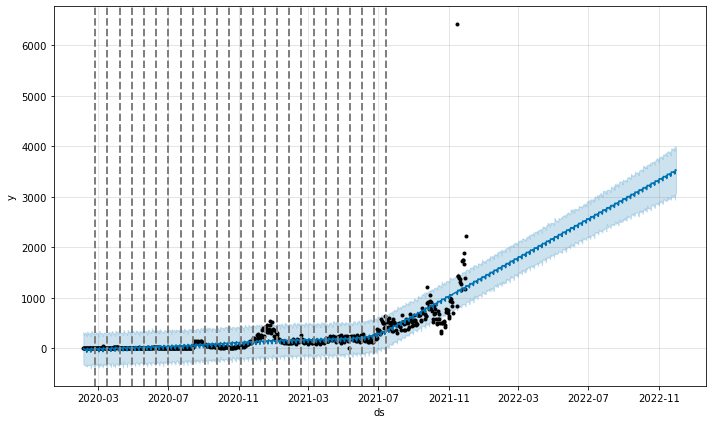

In [8]:
## 기본 설정
cpls = []
m = Prophet(changepoints=None,n_changepoints=25, changepoint_range=0.8, changepoint_prior_scale=0.05)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)
    cpls.append(cp)

In [10]:
cpls

[Timestamp('2020-02-26 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-04-08 00:00:00'),
 Timestamp('2020-04-29 00:00:00'),
 Timestamp('2020-05-20 00:00:00'),
 Timestamp('2020-06-10 00:00:00'),
 Timestamp('2020-07-02 00:00:00'),
 Timestamp('2020-07-23 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2020-09-03 00:00:00'),
 Timestamp('2020-09-24 00:00:00'),
 Timestamp('2020-10-15 00:00:00'),
 Timestamp('2020-11-05 00:00:00'),
 Timestamp('2020-11-26 00:00:00'),
 Timestamp('2020-12-17 00:00:00'),
 Timestamp('2021-01-07 00:00:00'),
 Timestamp('2021-01-28 00:00:00'),
 Timestamp('2021-02-18 00:00:00'),
 Timestamp('2021-03-12 00:00:00'),
 Timestamp('2021-04-02 00:00:00'),
 Timestamp('2021-04-23 00:00:00'),
 Timestamp('2021-05-13 00:00:00'),
 Timestamp('2021-06-03 00:00:00'),
 Timestamp('2021-06-24 00:00:00'),
 Timestamp('2021-07-15 00:00:00')]

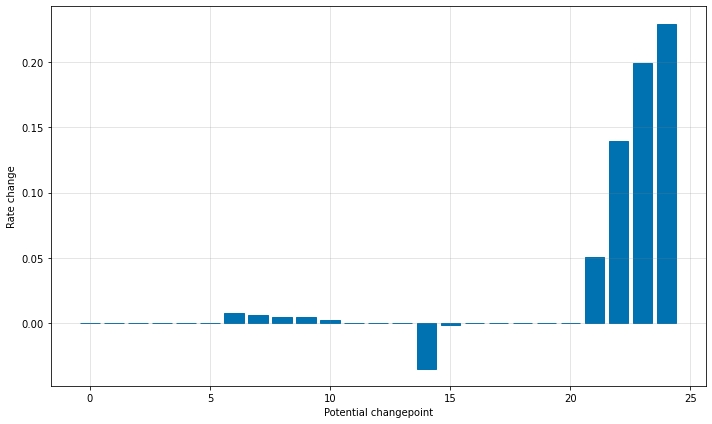

In [11]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

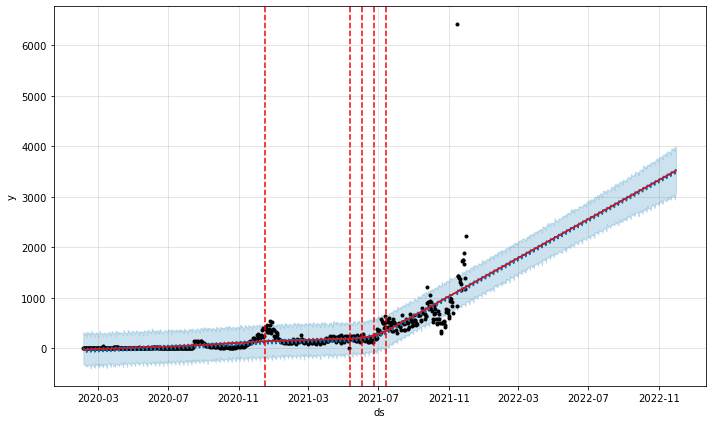

In [12]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


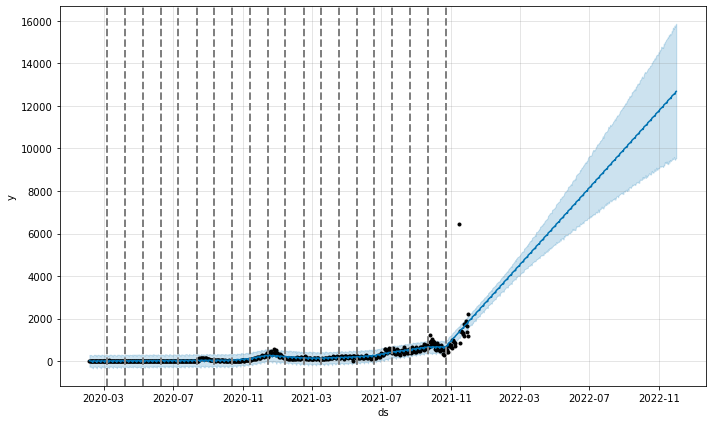

In [16]:
# 변경점 유연성과 범위를 늘리고, 잠재적 변경점 수 감소 (오버피팅 확률 증가)
cpls = []
m = Prophet(changepoints=None,n_changepoints=20,changepoint_range=0.95, changepoint_prior_scale=0.3)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)
    cpls.append(cp)

In [17]:
cpls

[Timestamp('2020-03-07 00:00:00'),
 Timestamp('2020-04-08 00:00:00'),
 Timestamp('2020-05-09 00:00:00'),
 Timestamp('2020-06-09 00:00:00'),
 Timestamp('2020-07-10 00:00:00'),
 Timestamp('2020-08-11 00:00:00'),
 Timestamp('2020-09-11 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-11-13 00:00:00'),
 Timestamp('2020-12-14 00:00:00'),
 Timestamp('2021-01-14 00:00:00'),
 Timestamp('2021-02-15 00:00:00'),
 Timestamp('2021-03-18 00:00:00'),
 Timestamp('2021-04-18 00:00:00'),
 Timestamp('2021-05-19 00:00:00'),
 Timestamp('2021-06-19 00:00:00'),
 Timestamp('2021-07-20 00:00:00'),
 Timestamp('2021-08-20 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2021-10-22 00:00:00')]

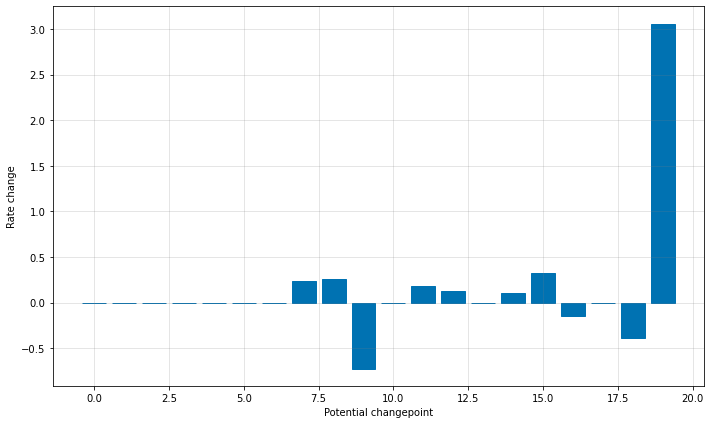

In [14]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

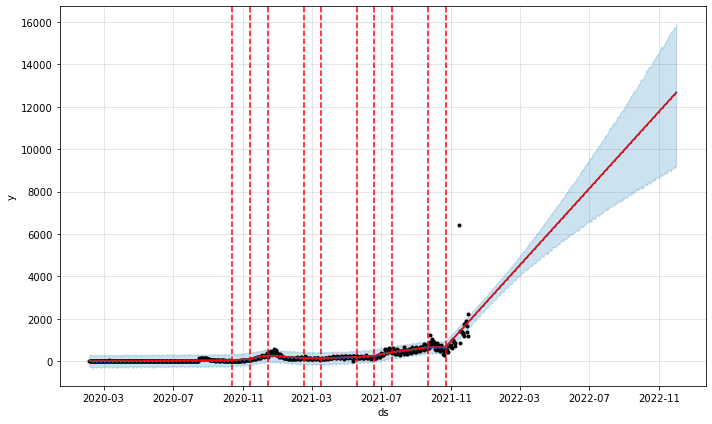

In [15]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)